In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as Axes3D
from matplotlib import cm, colors
from copy import deepcopy
from scipy import interpolate

### Field class

In [2]:
class field:
    def __init__(self,x_range,y_range,distance,N,Narray,darray,k0,omega,eps_0,eps_c):
        ### X pol
        try:
            E_carte = np.zeros((1,3,N,N),dtype=complex)
            E_phi = np.zeros((N,N),dtype=complex)
            for k in range(Narray):
                # Oxy plane
                z_ = np.linspace(x_range[0], x_range[1],N)
                y_ = np.linspace(y_range[0], y_range[1],N) - (Narray-1)*darray/2 + k*darray
                x = distance
                z, y = np.meshgrid(z_, y_)

                r = np.sqrt(np.multiply(z,z)+ + np.multiply(y,y) + x**2)
                phi = np.arctan2(y,x)
                theta = np.arccos(np.divide(z,r))

                # Single Hertirien Dipole 
                dem = (0+2j)*np.pi*omega*eps_0*eps_c*np.power(r,3)
                E_r = p*np.divide(np.multiply(np.multiply(np.cos(theta),1 + 1j*k0*r),np.exp(-1j*k0*r)),dem)
                E_theta = p*np.divide(np.multiply(np.multiply(np.sin(theta),1 + 1j*k0*r + np.power(1j*k0*r,2)),np.exp(-1j*k0*r)),2*dem)
                for i in range(N):
                    for j in range(N):
                        sphtransmat = np.matrix([[np.sin(theta[i,j])*np.cos(phi[i,j]), np.sin(theta[i,j])*np.sin(phi[i,j]), np.cos(theta[i,j])],
                                     [np.cos(theta[i,j])*np.cos(phi[i,j]), np.cos(theta[i,j])*np.sin(phi[i,j]), -np.sin(theta[i,j])],
                                     [-np.sin(phi[i,j]), np.cos(phi[i,j]), 0]])
                        E_carte[:,:,i,j] = E_carte[:,:,i,j] + np.matmul(np.matrix([E_r[i,j], E_theta[i,j], E_phi[i,j]]),sphtransmat)
                self.DX = -E_carte[0,2,:,:]
                self.DY = E_carte[0,1,:,:]
                self.DZ = E_carte[0,0,:,:]
        except OSError:
            print('No X field')
        self.X, self.Y = np.meshgrid(np.linspace(x_range[0], x_range[1],N),np.linspace(y_range[0], y_range[1],N))
        self.Z = distance
        self.N = N
        self.D = np.swapaxes(np.stack([self.DX, self.DY, self.DZ],axis=1),1,2)

In [3]:
def displayE(E) :
    fig, axs = plt.subplots(3, 2)
    axs[0, 0].pcolormesh(E.X,E.Y,abs(E.DX),shading='auto')
    axs[0, 0].set_title('X-Y-Z component - magnitude')
    axs[0, 1].pcolormesh(E.X,E.Y,np.angle(E.DX),shading='auto')
    axs[0, 1].set_title('X-Y-Z component - phase')
    
    axs[1, 0].pcolormesh(E.X,E.Y,abs(E.DY),shading='auto')
    axs[1, 1].pcolormesh(E.X,E.Y,np.angle(E.DY),shading='auto')
    
    axs[2, 0].pcolormesh(E.X,E.Y,abs(E.DZ),shading='auto')
    axs[2, 1].pcolormesh(E.X,E.Y,np.angle(E.DZ),shading='auto')
    
    for ax in axs.flat:
        ax.set(xlabel='x-axis', ylabel='y-axis')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

In [4]:
def propagation(E,Z,Nspec):
    dx = E.X[0,1] - E.X[0,0]
    dy = E.Y[1,0] - E.Y[0,0]
    kx = (-1/2 + (np.arange(Nspec))/Nspec)*(2*np.pi/dx)
    ky = (-1/2 + (np.arange(Nspec))/Nspec)*(2*np.pi/dy)
    KX,KY = np.meshgrid(kx,ky)
    KZ = np.conj(np.sqrt((k0**2-KX**2-KY**2)*(1+0j)))

    propagator = np.fft.ifftshift(np.exp(-1j*(Z-E.Z)*KZ))
        
    E_propagated = deepcopy(E)
    E_propagated.Z = E.Z
        #Matlab : E_rec.D = ifft2(propagateur.*fft2(E_anal.D));
    E_propagated.DX = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(E.DX)))
    E_propagated.DY = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(E.DY)))
    E_propagated.DZ = np.fft.ifft2(np.multiply(propagator,np.fft.fft2(E.DZ)))
    E_propagated.D = np.swapaxes(np.stack([E_propagated.DX, E_propagated.DY, E_propagated.DZ],axis=1),1,2)
    return E_propagated

In [5]:
def spectral(E,Nspec):
    dx = E.X[0,1] - E.X[0,0]
    dy = E.Y[1,0] - E.Y[0,0]
    kx = (-1/2 + (np.arange(Nspec))/Nspec)*(2*np.pi/dx)
    ky = (-1/2 + (np.arange(Nspec))/Nspec)*(2*np.pi/dy)
    KX,KY = np.meshgrid(kx,ky)
    KZ = np.conj(np.sqrt((k0**2-KX**2-KY**2)*(1+0j)))
        
    sE = deepcopy(E)
    sE.X = KX
    sE.Y = KY
    sE.Z = KZ
    sE.N = Nspec
    
    sE.DX = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E.DX)))
    sE.DY = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E.DY)))
    sE.DZ = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E.DZ)))
    sE.D = np.swapaxes(np.stack([sE.DX, sE.DY, sE.DZ],axis=1),1,2)
    return sE

# Handling coordinates

## Envinronment parameters

In [6]:
p = 1
eps_0 = 8.8541878128e-12
eps_c = 1
freq = 1e9
omega = 2*np.pi*freq
k0 = 2*np.pi*freq/299792458

## Array parameters

In [7]:
Narray = 1
darray = 0.15

# Calculate E-field of the array of Hertizien dipole

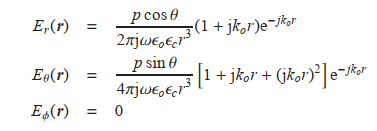

### Calculate E-field at 0.02m

In [8]:
x_range = [-1,1]
y_range = x_range
distance1 = 0.02
N = 501
Narray = 1
darray = 0.15

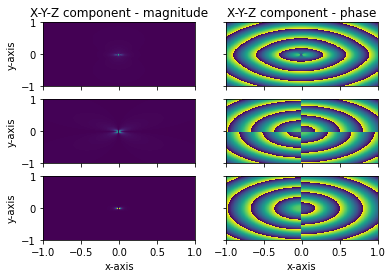

In [9]:
E_20mm = field(x_range,y_range,distance1,N,Narray,darray,k0,omega,eps_0,eps_c)
displayE(E_20mm)

### Calculate E-field at 0.1m

In [10]:
distance2 = 0.1

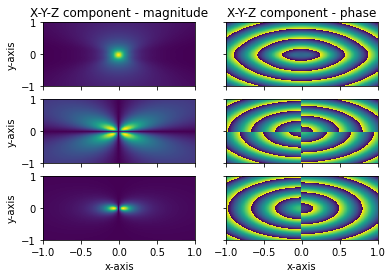

In [11]:
E_100mm = field(x_range,y_range,distance2,N,Narray,darray,k0,omega,eps_0,eps_c)
displayE(E_100mm)

# Plane wave spectral propagation

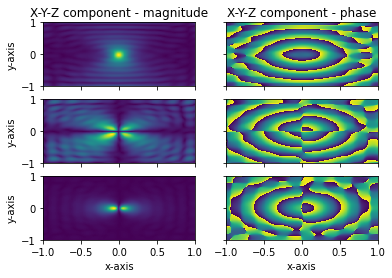

In [12]:
E_100mm_propagated = propagation(E_20mm,E_100mm.Z,E_100mm.N)
displayE(E_100mm_propagated)

# Far-field calculation 

In [13]:
Nspec = E_100mm.N
dx = E_20mm.X[0,1] - E_20mm.X[0,0]
dy = E_20mm.Y[1,0] - E_20mm.Y[0,0]
kx = (-1/2 + (np.arange(Nspec))/Nspec)*(2*np.pi/dx)
ky = (-1/2 + (np.arange(Nspec))/Nspec)*(2*np.pi/dy)
KX,KY = np.meshgrid(kx,ky)
KZ = np.conj(np.sqrt((k0**2-KX**2-KY**2)*(1+0j)))

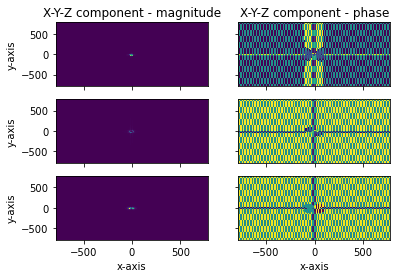

In [14]:
sE_100mm = spectral(E_100mm,E_100mm.N)
displayE(sE_100mm)

In [15]:
t = 90
theta_ = (np.arange(t)/(t-1))*np.pi
phi_ = (-1/2 + np.arange(t)/(t-1))*np.pi*2
Theta, Phi = np.meshgrid(theta_,phi_)
kx_spherical = np.zeros((t,t))
ky_spherical = np.zeros((t,t))
kz_spherical = np.zeros((t,t))

for m in range(t):
    for n in range(t):
        kx_spherical[n,m] = k0*np.sin(theta_[m])*np.cos(phi_[n])
        ky_spherical[n,m] = k0*np.sin(theta_[m])*np.sin(phi_[n])
        kz_spherical[n,m] = np.cos(theta_[m])
kx_spherical.shape

(90, 90)

Interpolating functions:

In [16]:
sE_FFX_fct_real = interpolate.interp2d(sE_100mm.X[0,:], sE_100mm.Y[:,0], np.real(sE_100mm.DX), kind='cubic')
sE_FFX_fct_imag = interpolate.interp2d(sE_100mm.X[0,:], sE_100mm.Y[:,0], np.imag(sE_100mm.DX), kind='cubic')

sE_FFY_fct_real = interpolate.interp2d(sE_100mm.X[0,:], sE_100mm.Y[:,0], np.real(sE_100mm.DY), kind='cubic')
sE_FFY_fct_imag = interpolate.interp2d(sE_100mm.X[0,:], sE_100mm.Y[:,0], np.imag(sE_100mm.DY), kind='cubic')

sE_FFZ_fct_real = interpolate.interp2d(sE_100mm.X[0,:], sE_100mm.Y[:,0], np.real(sE_100mm.DZ), kind='cubic')
sE_FFZ_fct_imag = interpolate.interp2d(sE_100mm.X[0,:], sE_100mm.Y[:,0], np.imag(sE_100mm.DZ), kind='cubic')

In [17]:
sE_FF = deepcopy(sE_100mm)
sE_FF.X = Theta
sE_FF.Y = Phi
sE_FF.Z = 0
sE_FF.N = t
sE_FF.DX = np.zeros((t,t),dtype=complex)
sE_FF.DY = np.zeros((t,t),dtype=complex)
sE_FF.DZ = np.zeros((t,t),dtype=complex)

for i in range(t):
    for j in range(t):
        sE_FF.DX[i,j] = sE_FFX_fct_real(kx_spherical[i,j],ky_spherical[i,j]) + 1j*sE_FFX_fct_imag(kx_spherical[i,j],ky_spherical[i,j])
        sE_FF.DY[i,j] = sE_FFY_fct_real(kx_spherical[i,j],ky_spherical[i,j]) + 1j*sE_FFY_fct_imag(kx_spherical[i,j],ky_spherical[i,j])
        sE_FF.DZ[i,j] = sE_FFZ_fct_real(kx_spherical[i,j],ky_spherical[i,j]) + 1j*sE_FFZ_fct_imag(kx_spherical[i,j],ky_spherical[i,j])

#sE_FF.DX = np.multiply(kz_spherical,sE_FF.DX)
#sE_FF.DY = np.multiply(kz_spherical,sE_FF.DY)   
#sE_FF.DZ = np.multiply(kz_spherical,sE_FF.DZ)   
sE_FF.D = np.swapaxes(np.stack([sE_FF.DX, sE_FF.DY, sE_FF.DZ],axis=1),1,2)
sE_FF.D.shape

(90, 90, 3)

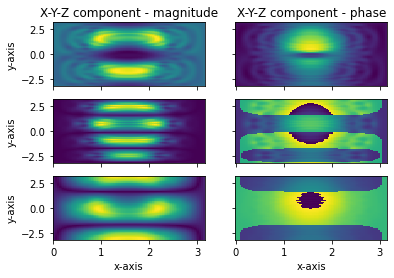

In [18]:
displayE(sE_FF)

In [19]:
FF_3D = np.sqrt(np.power(abs(sE_FF.DX),2) + np.power(abs(sE_FF.DY),2) + np.power(abs(sE_FF.DZ),2))

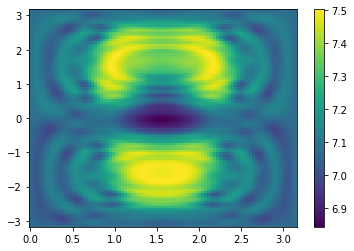

In [20]:
plt.pcolormesh(Theta,Phi,np.log10(FF_3D),shading='auto')
plt.colorbar()
plt.show()

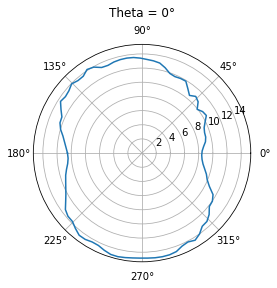

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi_[:], -60 + 10*np.log10(FF_3D[:,45]))
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Theta = 0°", va='bottom')
plt.show()

In [22]:
X = (-60 + 10*np.log10(FF_3D)) * np.sin(Theta) * np.cos(Phi)
Y = (-60 + 10*np.log10(FF_3D)) * np.sin(Theta) * np.sin(Phi)
Z = (-60 + 10*np.log10(FF_3D)) * np.cos(Theta)

In [23]:
X.shape

(90, 90)

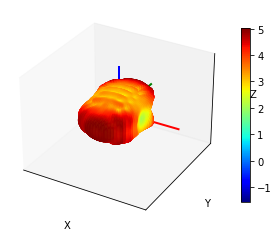

In [24]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1, projection='3d')
ax.grid(True)
ax.axis('on')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

N_ = np.sqrt(X**2 + Y**2 + Z**2)
Rmax = np.max(N_)
N_ = N_/Rmax

axes_length = 1.5
ax.plot([0, axes_length*Rmax], [0, 0], [0, 0], linewidth=2, color='red')
ax.plot([0, 0], [0, axes_length*Rmax], [0, 0], linewidth=2, color='green')
ax.plot([0, 0], [0, 0], [0, axes_length*Rmax], linewidth=2, color='blue')

mycol = cm.jet(N_)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=mycol, linewidth=0.5, antialiased=True, shade=False)  # , alpha=0.5, zorder = 0.5)

ax.set_xlim([-axes_length*Rmax, axes_length*Rmax])
ax.set_ylim([-axes_length*Rmax, axes_length*Rmax])
ax.set_zlim([-axes_length*Rmax, axes_length*Rmax])

m = cm.ScalarMappable(cmap=cm.jet)
m.set_array((-70 + 10*np.log10(FF_3D)))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.colorbar(m, shrink=0.8)
ax.view_init(azim=300, elev=30)

plt.show()